In [73]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd

'/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sedelkin/analytics_practice'

In [3]:
# Import connection data from local .txt file
import json 
connection_name = 'connection_default'

# read the data from the file 
with open('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sedelkin/practice/API/pandahouse_' + connection_name + '.txt') as f: 
    data = f.read() 
      
# reconstruct the data as a dictionary 
connection = json.loads(data) 

In [4]:
q = '''
    SELECT 
        COUNT(*)
    FROM 
        ldn_listings
'''
q_test = ph.read_clickhouse(query=q, connection=connection)
q_test

,count()
0,85207


In [5]:
# Load a sample
q_price_by_type = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    FROM 
        ldn_listings
    ORDER BY id ASC
    LIMIT 1000
'''

price_by_type = ph.read_clickhouse(query=q_price_by_type, connection=connection)
price_by_type.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


In [6]:
# Calculate 75th percentile for each room type
price_by_type.groupby('room_type').quantile(.75)

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


In [7]:
# Load another sample
q = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) AS review_scores_rating
    FROM 
        ldn_listings
    WHERE review_scores_rating is not null
    ORDER BY id ASC
    LIMIT 1000
'''

price_rating_by_type = ph.read_clickhouse(query=q, connection=connection)
price_rating_by_type.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [8]:
# Calculate mean values and plot them on the scatterplot
mean_price_rating_by_type = price_rating_by_type.groupby('room_type', as_index=False).mean()

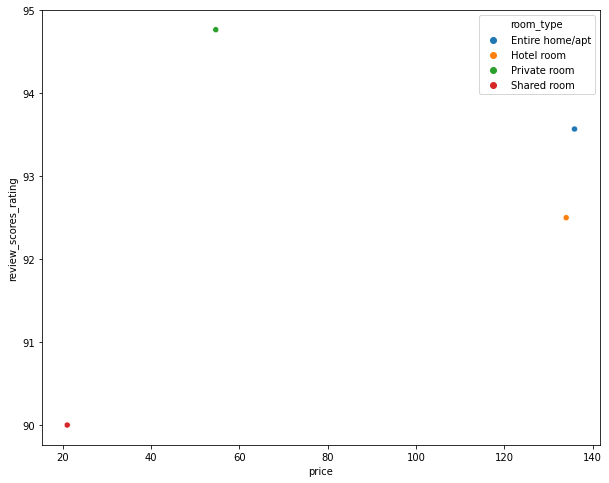

In [9]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=mean_price_rating_by_type, x='price', y='review_scores_rating', hue='room_type')

In [26]:
# Calculate the number of hosts that post experiences, that have used Google for verification
q = '''
    SELECT DISTINCT
        host_id,
        host_verifications
    FROM 
        ldn_listings
    WHERE experiences_offered != 'none'
'''
experience_host_verifications = ph.read_clickhouse(query=q, connection=connection)
experience_host_verifications.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [27]:
experience_host_verifications['verifications_list'] = experience_host_verifications.host_verifications.apply(lambda x: json.loads(x.replace("'", '"')))
experience_host_verifications

,host_id,host_verifications,verifications_list
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off...","[email, phone, facebook, reviews, offline_gove..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern...","[email, phone, reviews, jumio, government_id]"
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm...","[email, phone, jumio, selfie, government_id, i..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ...","[email, phone, manual_offline, jumio, offline_..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm...","[email, phone, reviews, offline_government_id,..."
...,...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern...","[email, phone, reviews, jumio, government_id]"
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin...","[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern...","[email, phone, reviews, jumio, government_id]"
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio...","[email, phone, google, reviews, jumio, offline..."


In [28]:
experience_host_verifications.verifications_list[0][0]

'email'

In [29]:
experience_host_verifications.verifications_list.explode().value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: verifications_list, dtype: int64

In [30]:
# Draw a heatmap of number of experiences of different types by district

q = '''
    SELECT
        neighbourhood_cleansed,
        experiences_offered,
        COUNT(*) AS experiences_count
    FROM 
        ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY 
        neighbourhood_cleansed,
        experiences_offered
    ORDER BY 
        experiences_count DESC
    LIMIT 100
'''
experience_types_by_neigbourhood = ph.read_clickhouse(query=q, connection=connection)
experience_types_by_neigbourhood.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [59]:
experiences_pivot = experience_types_by_neigbourhood.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
experiences_pivot.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


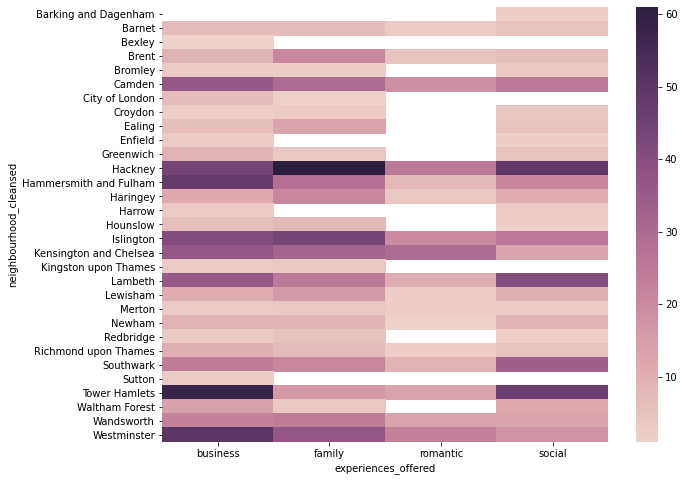

In [58]:
plt.figure(figsize=(10, 8))
sns.heatmap(experiences_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

In [67]:
# Explore room price for listings with connected experiences, visualise using charts

q = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr
    FROM 
        ldn_listings
    WHERE experiences_offered != 'none'
'''
experience_room_price = ph.read_clickhouse(query=q, connection=connection)
experience_room_price.head()

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


In [78]:
experience_room_price.room_type.value_counts()

Entire home/apt    922
Private room       613
Shared room          9
Hotel room           4
Name: room_type, dtype: int64

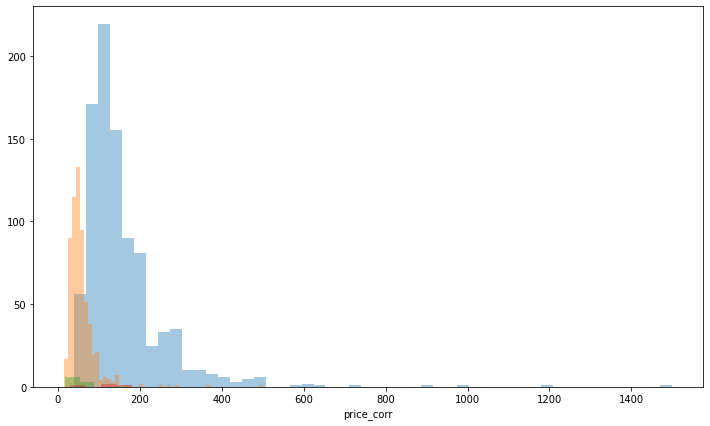

In [82]:
plt.figure(figsize=(12, 7))
sns.distplot(experience_room_price.query("room_type=='Entire home/apt'").price_corr, kde=False, label='Entire home/apt')
sns.distplot(experience_room_price.query("room_type=='Private room'").price_corr, kde=False, label='Private room')
sns.distplot(experience_room_price.query("room_type=='Shared room'").price_corr, kde=False, label='Shared room')
sns.distplot(experience_room_price.query("room_type=='Hotel room'").price_corr, kde=False, label='Hotel room')

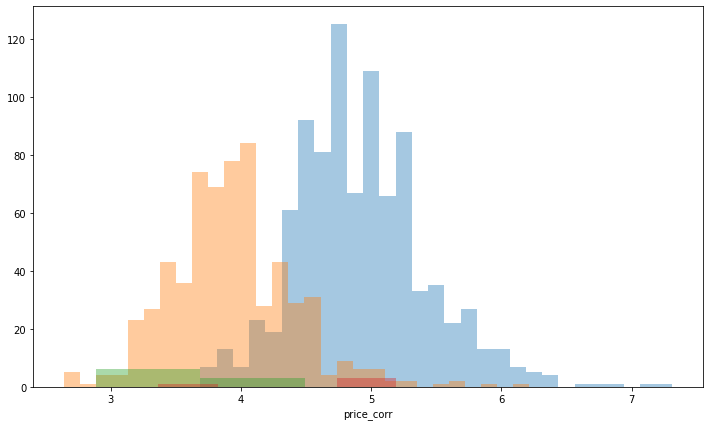

In [84]:
plt.figure(figsize=(12, 7))
sns.distplot(np.log(experience_room_price.query("room_type=='Entire home/apt'").price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(experience_room_price.query("room_type=='Private room'").price_corr), kde=False, label='Private room')
sns.distplot(np.log(experience_room_price.query("room_type=='Shared room'").price_corr), kde=False, label='Shared room')
sns.distplot(np.log(experience_room_price.query("room_type=='Hotel room'").price_corr), kde=False, label='Hotel room')

In [140]:
q = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
        toDate(first_review) AS first_review_date
    FROM 
        ldn_listings
    WHERE 
        first_review != 'none'
        AND first_review > '2010-01-01'
    LIMIT 1000
'''
room_types_by_first_review = ph.read_clickhouse(query=q, connection=connection)
room_types_by_first_review.head()

,room_type,price_corr,first_review_date
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [141]:
room_types_by_first_review.dtypes

room_type                    object
price_corr                  float32
first_review_date    datetime64[ns]
dtype: object

In [142]:
# Explore room type pryces by year, draw a line chart of them
room_types_by_first_review['year'] = room_types_by_first_review.first_review_date.apply(lambda x: x.year)
room_types_by_first_review.drop(columns=['first_review_date'], inplace=True)
room_types_by_first_review

,room_type,price_corr,year
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [143]:
room_type_price_by_year=room_types_by_first_review.groupby(["year", "room_type"], as_index=False).agg({'price_corr': 'mean'})
room_type_price_by_year.head()

,year,room_type,price_corr
0,2010,Entire home/apt,103.500000
1,2010,Hotel room,88.000000
2,2010,Private room,56.428570
3,2011,Entire home/apt,128.792450
4,2011,Private room,52.607143


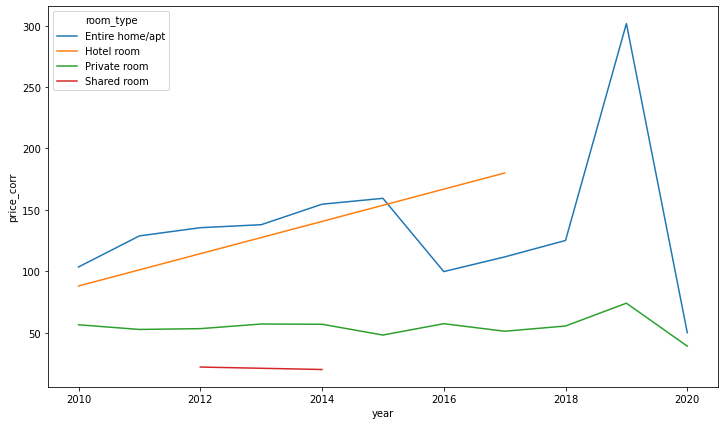

In [144]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=room_type_price_by_year, x='year', y='price_corr', hue='room_type')